# Valeurs des machins

In [12]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from uncertainties import unumpy as unp
from uncertainties import ufloat, umath, ufloat_fromstr
import uncertainties as un
from options import *
from pathlib import Path

mpl.rcParams.update(rcParams)

In [3]:
fits = {}

with open('fits.csv', 'r') as f:
    lines = f.readlines()
    for line in lines:
        if line.startswith('G'):
            name, a, b = line.replace('\n', '').split(',')
            fits[name] = [ufloat_fromstr(a), ufloat_fromstr(b)]

fits

{'G1-anneau': [0.00867+/-0.00024, -0.2342+/-0.0017],
 'G1-cylindre-acier-argent-chrome': [0.03972+/-0.00021, -0.023+/-0.0012],
 'G1-cylindre-acier-doux': [0.0474+/-0.00015, 0.0192+/-0.0008],
 'G1-cylindre-alu': [0.019027+/-5e-06, 0.000694+/-1e-05],
 'G1-cylindre-cuivre': [0.018744+/-2.5e-05, 0.002112+/-3.2e-05],
 'G1-cylindre-laiton': [0.019291+/-5e-06, -0.00084+/-7e-06],
 'G1-cylindre-monel400': [0.020996+/-1.2e-05, -0.026+/-7e-05],
 'G1-cylindre-nickel200': [0.021185+/-2.4e-05, -0.02978+/-0.00013],
 'G1-cylindre-vide': [0.01913+/-6e-06, 9.2e-05+/-7e-06],
 'G1-phywe-acdoux-combo': [0.0896+/-0.0005, 0.0169+/-0.0015],
 'G1-phywe-acdoux': [0.0798+/-0.00027, 0.0524+/-0.0011],
 'G1-phywe-alu-combo': [0.07529+/-6e-05, 0.00083+/-4e-05],
 'G1-phywe-alu': [0.07436+/-5e-05, 0.00336+/-4e-05],
 'G1-phywe-avec-bloc-horiz': [0.04399+/-0.00028, -0.0419+/-0.0009],
 'G1-phywe-avec-bloc-penche': [0.0579+/-0.0004, -0.0113+/-0.0014],
 'G1-phywe-avec-bloc': [0.0904+/-0.0006, 0.0109+/-0.001],
 'G1-phywe-cu

In [4]:
print(fits.get('G1-phywe-vide'))

[0.06899+/-8e-05, 0.000869+/-8e-06]


# Calcul $\mu_r$

## PHYWE

In [21]:
alph_phywe = fits.get('G1-phywe-vide')[0]

def mu_r(fit):
    return fit[0]/alph_phywe

mu = {}

for key, values in fits.items():
    if "G1-phywe" in key:
        temp_mu: un.UFloat = mu_r(values)
        temp_mu += ufloat(0, temp_mu.std_dev * 10)
        mu.update({key: temp_mu})
        print(f"{key}: mu_r = {temp_mu:.1uL}")
        

G1-phywe-acdoux-combo: mu_r = 1.30 \pm 0.07
G1-phywe-acdoux: mu_r = 1.16 \pm 0.04
G1-phywe-alu-combo: mu_r = 1.09 \pm 0.02
G1-phywe-alu: mu_r = 1.08 \pm 0.01
G1-phywe-avec-bloc-horiz: mu_r = 0.64 \pm 0.04
G1-phywe-avec-bloc-penche: mu_r = 0.84 \pm 0.06
G1-phywe-avec-bloc: mu_r = 1.31 \pm 0.09
G1-phywe-cuivre-combo: mu_r = 1.10 \pm 0.01
G1-phywe-cuivre: mu_r = 1.08 \pm 0.01
G1-phywe-vide: mu_r = 1.0 \pm 0


## Cylindre

In [23]:
alph_cyl = fits.get('G1-cylindre-vide')[0]

def mu_r(fit):
    return fit[0]/alph_cyl


for key, values in fits.items():
    if "G1-cylindre" in key:
        temp_mu = mu_r(values)
        temp_mu += ufloat(0, temp_mu.std_dev * 10)
        mu.update({key: temp_mu})
        print(f"{key}: mu_r = \\({temp_mu:.1uL}\\)")

G1-cylindre-acier-argent-chrome: mu_r = \(2.1 \pm 0.1\)
G1-cylindre-acier-doux: mu_r = \(2.48 \pm 0.08\)
G1-cylindre-alu: mu_r = \(0.995 \pm 0.004\)
G1-cylindre-cuivre: mu_r = \(0.98 \pm 0.01\)
G1-cylindre-laiton: mu_r = \(1.008 \pm 0.004\)
G1-cylindre-monel400: mu_r = \(1.098 \pm 0.007\)
G1-cylindre-nickel200: mu_r = \(1.11 \pm 0.01\)
G1-cylindre-vide: mu_r = \(1.0 \pm 0\)


# Calibration des axes

## PHYWE

In [7]:
mu_0 = 4*np.pi*(10**(-7))

N_phywe = 600 # l'autre 1200
L_phywe = ufloat_fromstr("0.064 +/- 0.001")


def C1_phywe(mu_r):
    return N_phywe/(mu_r * L_phywe)


def C2_phywe(mu_r):
    return mu_0 * N_phywe/( L_phywe*alph_phywe*mu_r )


def H_phywe(Vx, mu_r):
    return C1_phywe(mu_r) * Vx

def B_phywe(Vy, mu_r):
    return C2_phywe(mu_r) * Vy


C1 pour G1-phywe-avec-bloc: (7.15+/-0.12)e+03 et C2 pour G1-phywe-avec-bloc: 0.1303+/-0.0022


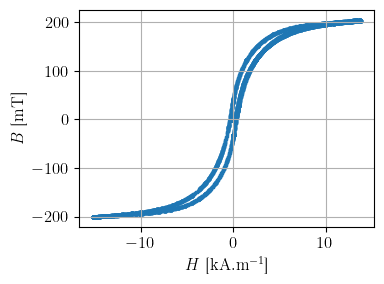

In [8]:
mater = "G1-phywe-avec-bloc"

datas = pd.read_csv(f"../data/{mater}.csv", header=None)

mu_data = mu.get(mater)


H_datas = C1_phywe(mu_data).nominal_value*datas[0]/1000
B_datas = C2_phywe(mu_data).nominal_value*datas[1]*1000

print(f"C1 pour {mater}: {C1_phywe(mu_data)} et C2 pour {mater}: {C2_phywe(mu_data)}")
plt.scatter(H_datas, B_datas, marker="s", s=1)
plt.grid()
plt.xlabel(r"$H$ [kA.m$^{-1}$]")
plt.ylabel(r"$B$ [mT]")
plt.tight_layout()
plt.savefig(f"../figures/{mater}_chang.pdf")

## Cylindre

In [8]:
N_cyl = 405
L_cyl = ufloat_fromstr("0.111 +/- 0.001")


def C1_cylindre(mu_r):
    return N_cyl/(mu_r * L_cyl)


def C2_cylindre(mu_r):
    return mu_0 * N_cyl/( L_cyl*alph_cyl*mu_r )


def H_cyl(Vx, mu_r):
    return C1_cylindre(mu_r) * Vx

def B_cyl(Vy, mu_r):
    return C2_cylindre(mu_r) * Vy

NameError: name 'ufloat_fromstr' is not defined

C1 pour G1-cylindre-nickel200: 2438+/-33 et C2 pour G1-cylindre-nickel200: 0.1602+/-0.0021


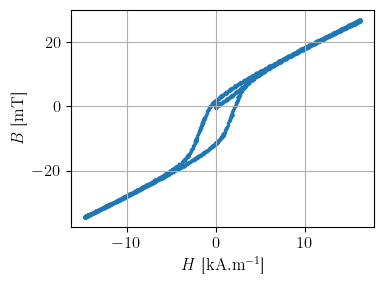

In [9]:
mater = "G1-cylindre-nickel200"

datas = pd.read_csv(f"../data/{mater}.csv", header=None)

mu_data = mu.get(mater)

print(f"C1 pour {mater}: {C1_cylindre(mu_data)} et C2 pour {mater}: {C2_cylindre(mu_data)}")
plt.scatter(C1_cylindre(mu_data).nominal_value*datas[0]/1000, C2_cylindre(mu_data).nominal_value*datas[1]*1000, marker="s", s=1)
plt.grid()
plt.xlabel(r"$H$ [kA.m$^{-1}$]")
plt.ylabel(r"$B$ [mT]")
plt.tight_layout()
plt.savefig(f"../figures/{mater}_chang.pdf")